In [14]:
import matplotlib.pyplot as plt 
import pandas as pd 

In [15]:
lanl_log = '../pretrained/rw_sampling/lanl14argus/rw_bert_lanl14argus_log_tiny.txt'
lanl_df = pd.read_csv(lanl_log, names=['loss', 'updates', 'tokens', 'time'])

unsw_log = '../pretrained/rw_sampling/unsw/rw_bert_unsw_log_tiny.txt'
unsw_df = pd.read_csv(unsw_log, names=['loss', 'updates', 'tokens', 'time'])

optc_log = '../pretrained/rw_sampling/optc/rw_bert_optc_log_tiny.txt'
optc_df = pd.read_csv(optc_log, names=['loss', 'updates', 'tokens', 'time'])

In [16]:
lanl_df['time'].sum()

1614.5975489616394

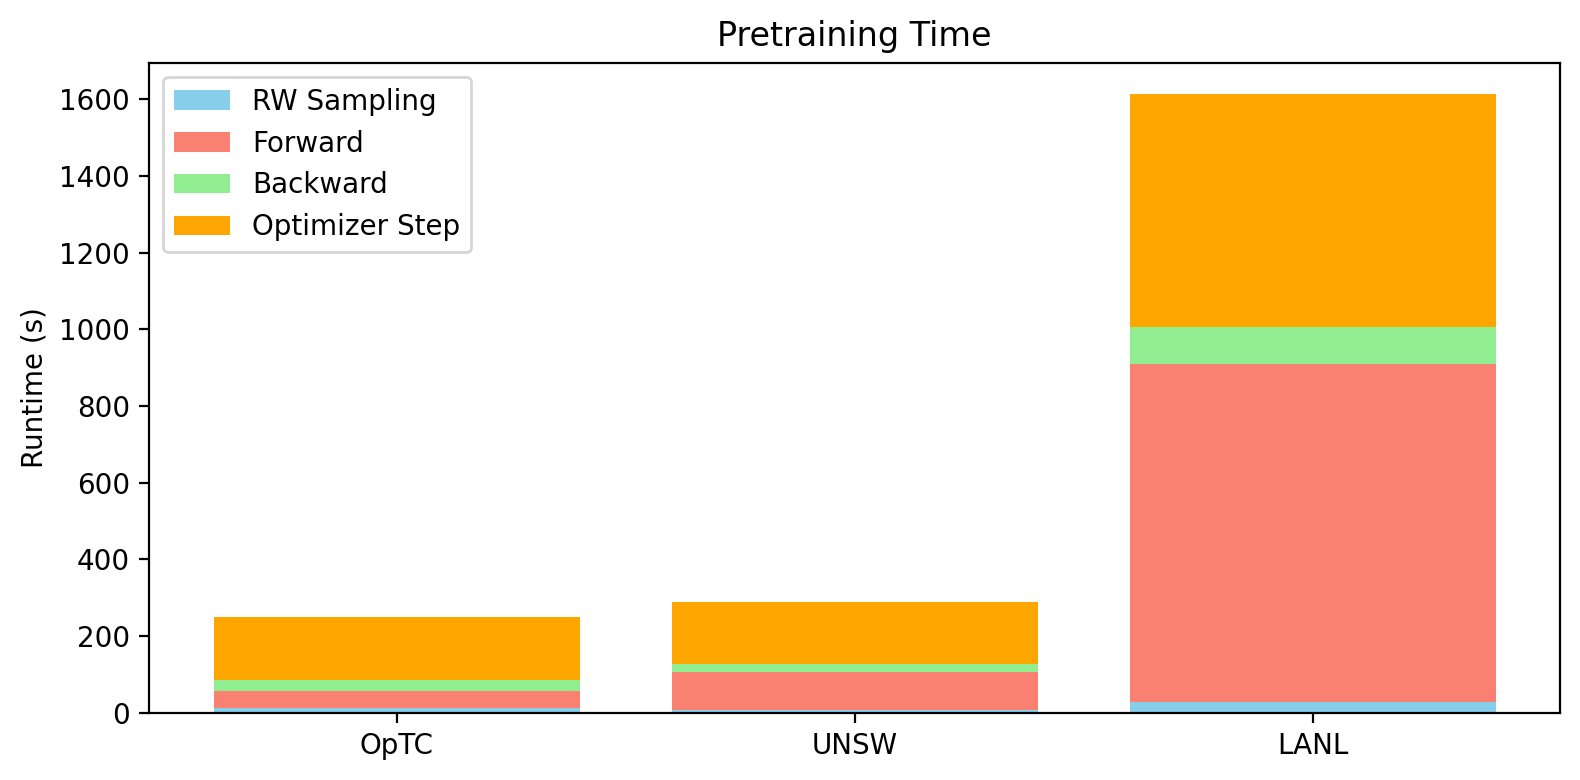

In [17]:
import numpy as np 
df_map = {'optc': optc_df, 'unsw': unsw_df, 'lanl': lanl_df}

print()

rows = []
for ds in ['optc', 'unsw', 'lanl']:
    latency_df = pd.read_csv(f'../latency/latency_{ds}.csv')
    l = latency_df.sum().to_dict()
    
    # Normalize
    tot = sum(l.values())
    for k in l: 
        l[k] /= tot 

    l['dataset'] = ds 
    l['total'] = df_map[ds]['time'].sum()

    rows.append(l)

# Extract data
datasets = ['OpTC', 'UNSW', 'LANL']
totals = [r['total'] for r in rows]

# The categories for stacking
parts = ['samp', 'fwd', 'bwd', 'step']
labels = ['RW Sampling', 'Forward', 'Backward', 'Optimizer Step']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

# Build stacked values (proportion * total)
stacked_values = {part: [r[part] * r['total'] for r in rows] for part in parts}

# Plot
x = np.arange(len(rows))
plt.figure(figsize=(8, 4), dpi=200)

bottom = np.zeros(len(rows))
for i,part in enumerate(parts):
    plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
    bottom += stacked_values[part]

plt.xticks(x, datasets)
plt.ylabel("Runtime (s)")
plt.title("Pretraining Time")
plt.legend()

plt.tight_layout()
plt.show()

[{'samp': 0.41182732582092285, 'fwd': 6.813671588897705, 'bwd': 2.4728872776031494, 'step': 0.6031866073608398, 'dataset': 'optc'}, {'samp': 4.066596508026123, 'fwd': 108.61317014694214, 'bwd': 4.876992702484131, 'step': 123.49532008171082, 'dataset': 'unsw'}, {'samp': 6.4775025844573975, 'fwd': 283.81952357292175, 'bwd': 26.18843388557434, 'step': 952.2662210464478, 'dataset': 'lanl'}]

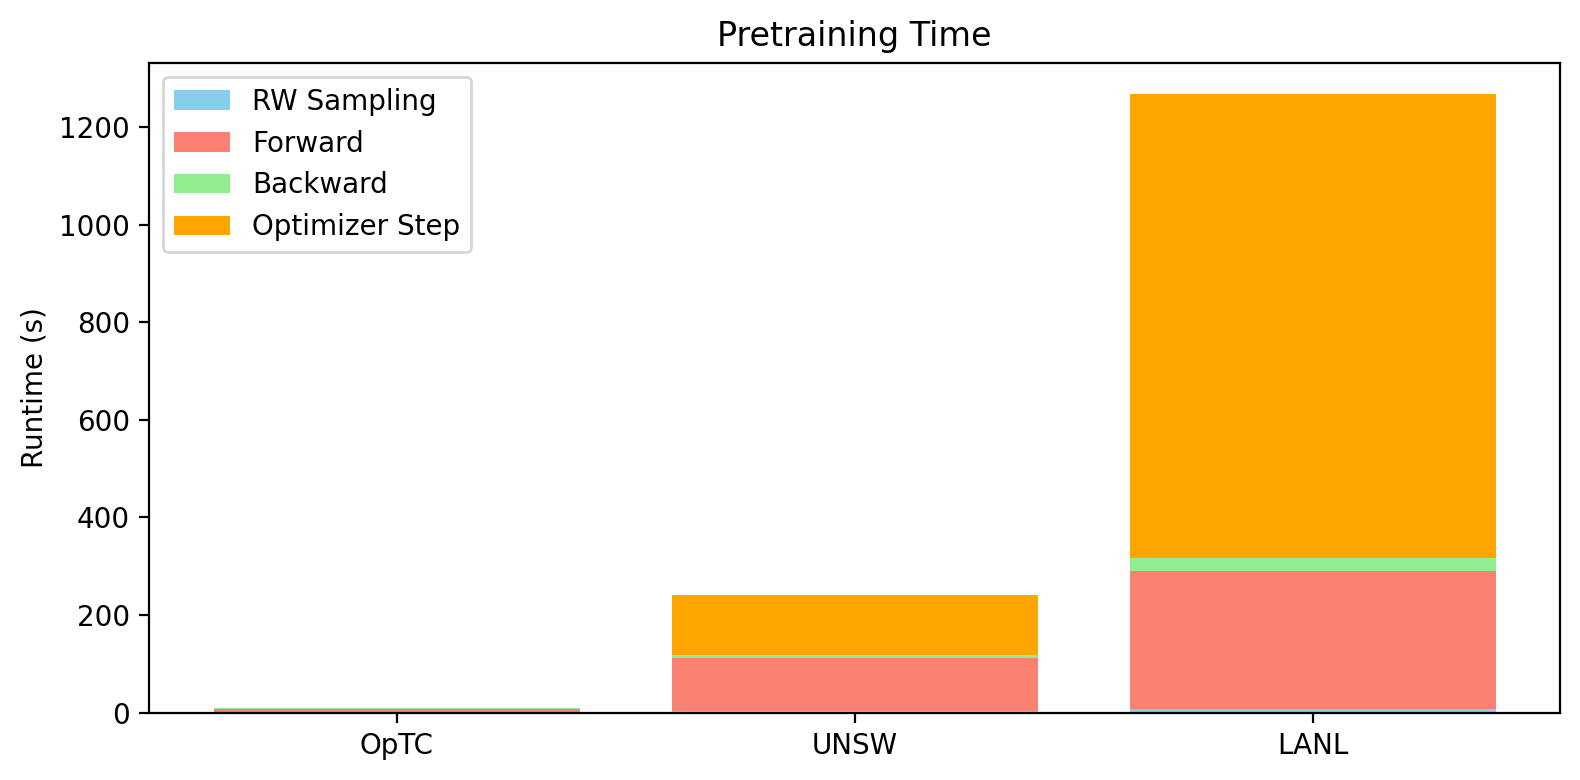

In [ ]:
import json 
rows = []
for ds in ['optc', 'unsw', 'lanl']:
    with open(f'../latency/latency_{ds}_ft.json', 'r') as f:
        latency = json.load(f)

    for k in latency: 
        latency[k] = sum(latency[k])
    
    latency['dataset'] = ds 
    rows.append(latency)

print(rows)

# Extract data
datasets = ['OpTC', 'UNSW', 'LANL']

# The categories for stacking
parts = ['samp', 'fwd', 'bwd', 'step']
labels = ['RW Sampling', 'Forward', 'Backward', 'Optimizer Step']
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

# Build stacked values (proportion * total)
stacked_values = {part: [r[part] for r in rows] for part in parts}

# Plot
x = np.arange(len(rows))
plt.figure(figsize=(8, 4), dpi=200)

bottom = np.zeros(len(rows))
for i,part in enumerate(parts):
    plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
    bottom += stacked_values[part]

plt.xticks(x, datasets)
plt.ylabel("Runtime (s)")
plt.title("Finetuning Time")
plt.legend()

plt.tight_layout()
plt.show()

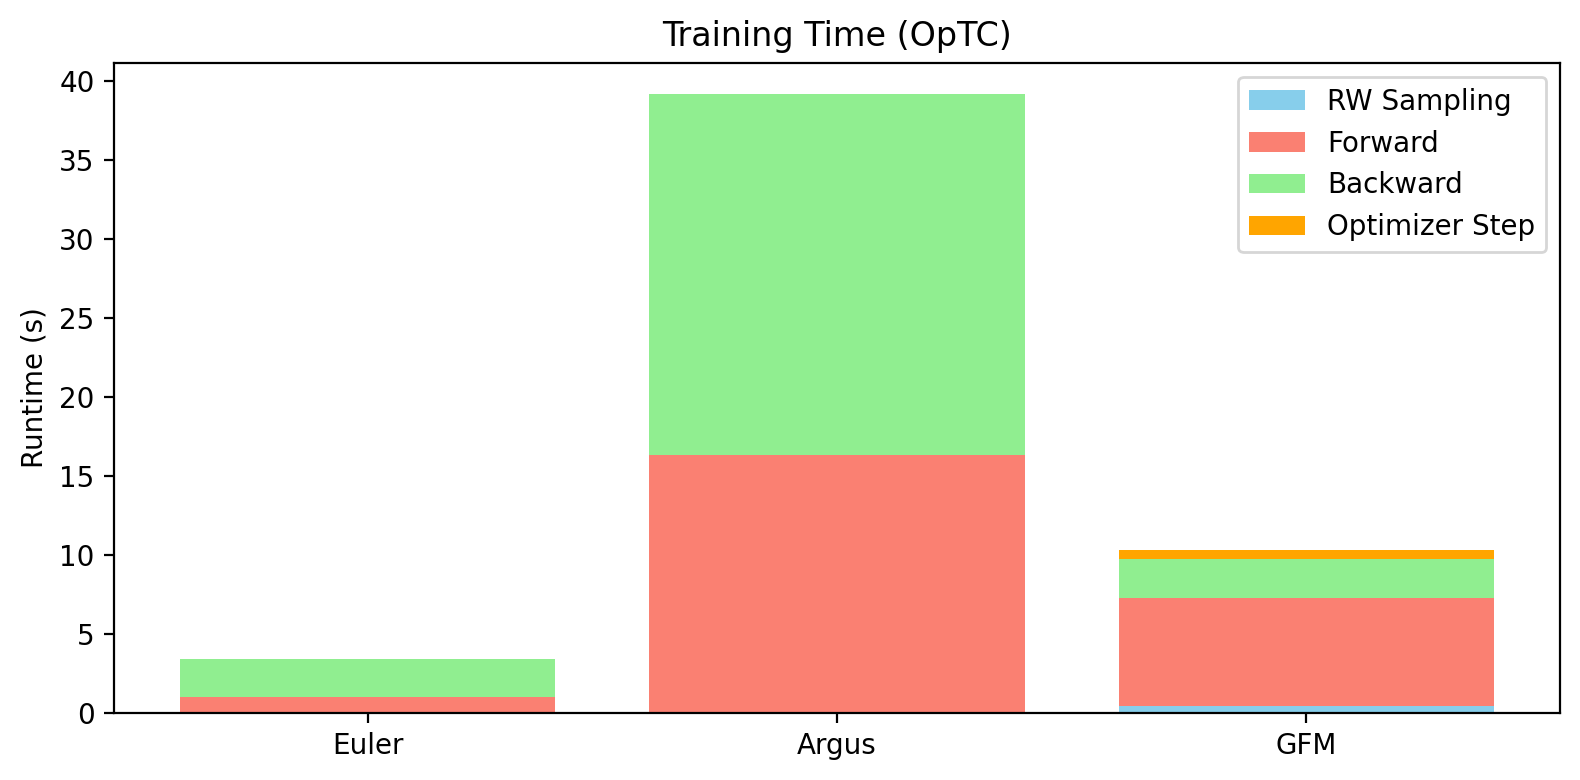

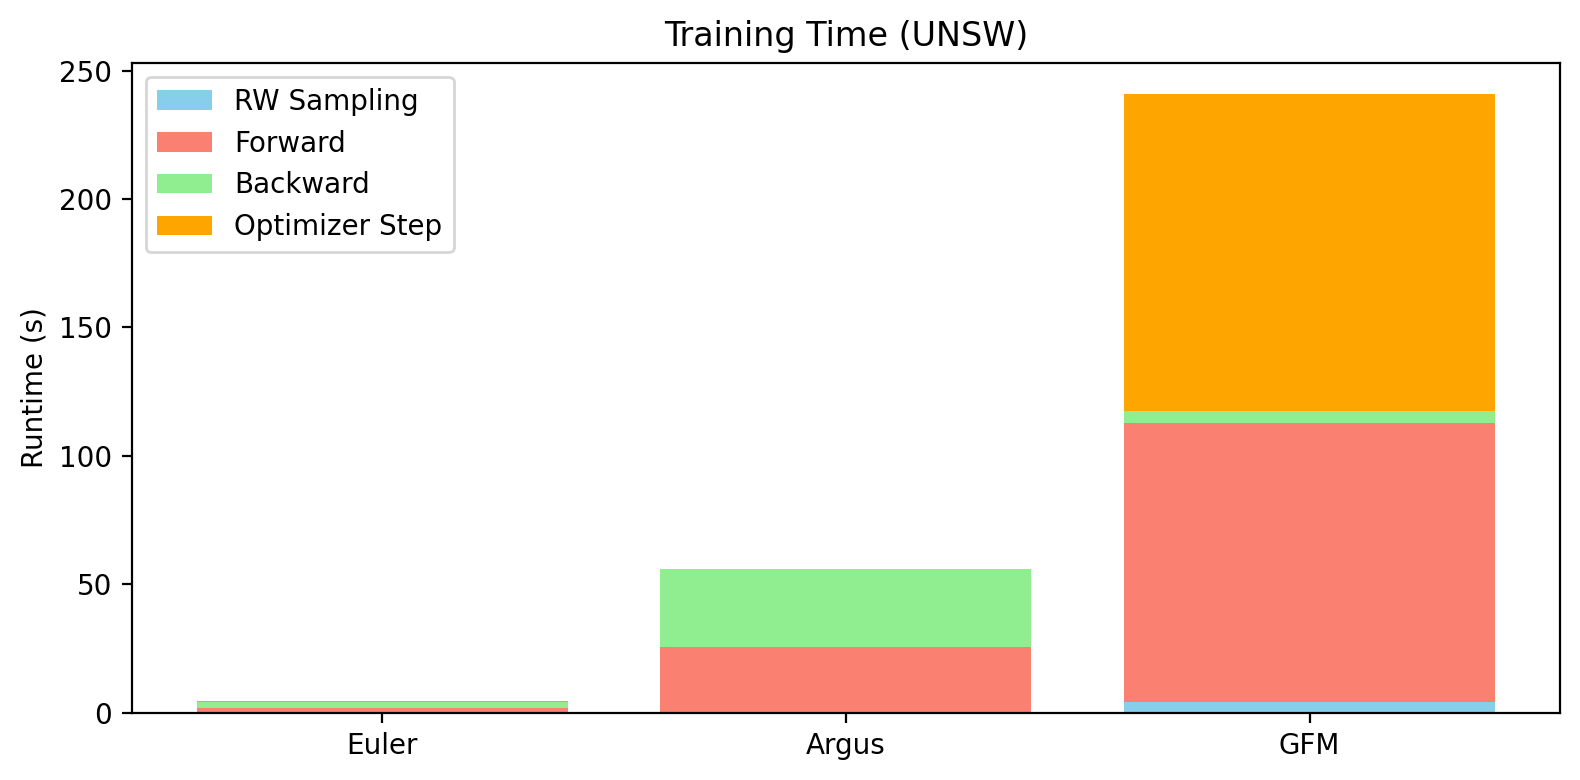

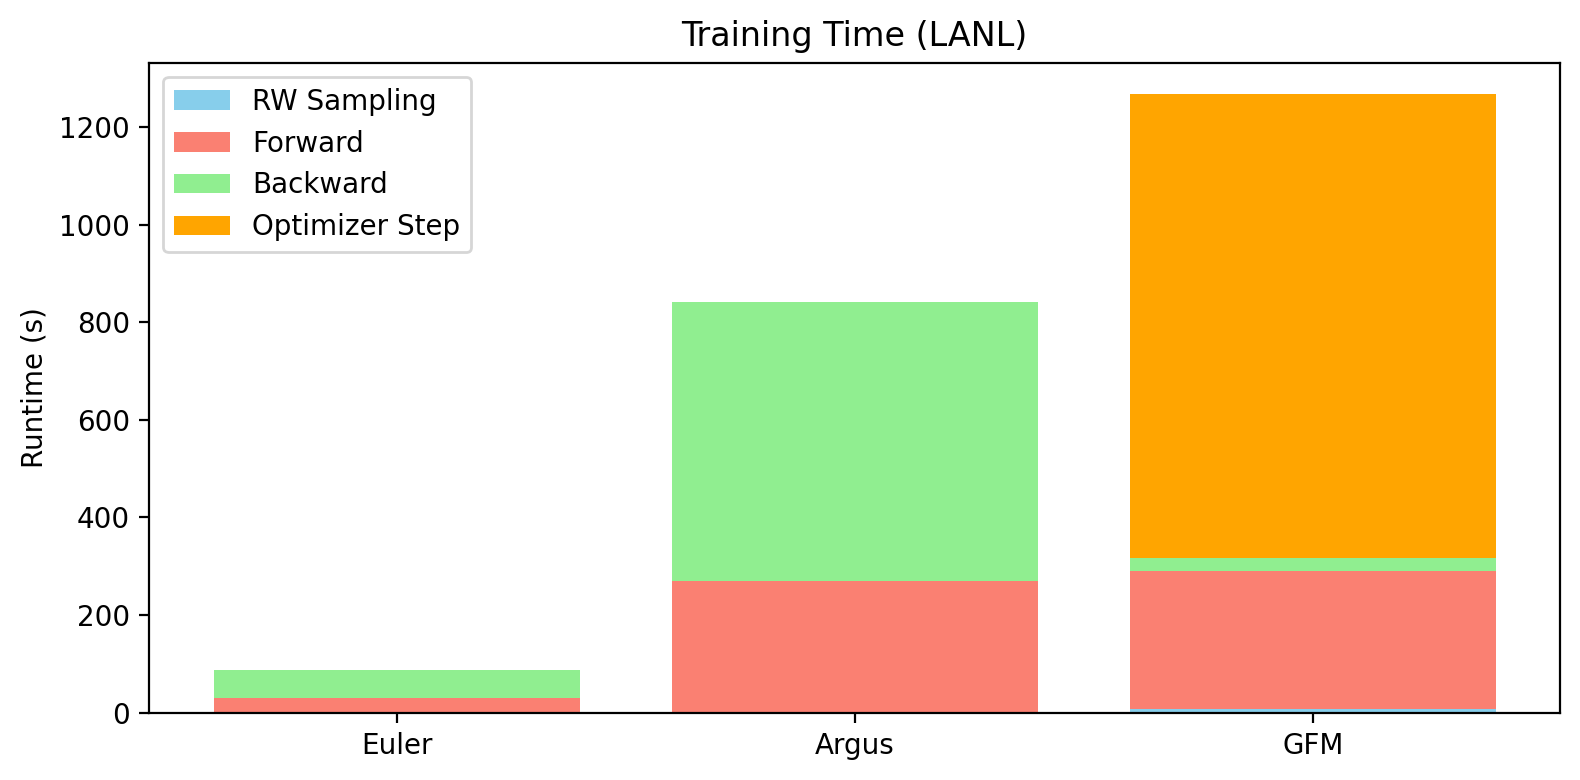

In [33]:
for ds in ['optc', 'unsw', 'lanl']:
    models = []
    times = []
    with open(f'../latency/comparison/{ds}_latencies.csv', 'r') as f: 
        line = f.readline() 
        while line: 
            tokens = line.split(',')
            models.append(tokens[0])

            ts =  [float(t) for t in tokens[1:]]
            ts[1] += ts[2]
            ts = ts[:2] + ts[3:]
            times.append(ts)
            line = f.readline()

    labels = ['RW Sampling', 'Forward', 'Backward', 'Optimizer Step']
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

    # Build stacked values (proportion * total)
    stacked_values = {part: [r[i] for r in times] for i,part in enumerate(labels)}

    # Plot
    x = np.arange(len(rows))
    plt.figure(figsize=(8, 4), dpi=200)

    bottom = np.zeros(len(rows))
    for i,part in enumerate(labels):
        plt.bar(x, stacked_values[part], bottom=bottom, label=labels[i], color=colors[i])
        bottom += stacked_values[part]

    plt.xticks(x, models)
    plt.ylabel("Runtime (s)")
    plt.title(f"Training Time ({ds.upper().replace('P', 'p')})")
    plt.legend()

    plt.tight_layout()
    plt.show()